# Installs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/MyDrive/isbi2024/lung/'

In [ ]:
!pip install alibi[tensorflow]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing instal

# Libraries

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import random as rn
from time import time
import seaborn as sns
from sklearn.metrics import classification_report

# Display graphs in a Jupyter
%matplotlib inline

In [ ]:
# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

from alibi.explainers import Counterfactual
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.14.1
Eager execution enabled:  False


# Functions
These are helper functions, used for various tasks throught the notebook. We just need to execute the whole block `Functions` in order to import them in the notebook

## Read functions

In [ ]:
# def read_data(data_paths):
#     """
#     Function for reading data from folders.
#     Returns numpy array [img, label]
#     """
#     for data_path in data_paths:
#         labels = ['PNEUMONIA', 'NORMAL']
#         images = []
#         y = []
#         for label in labels:
#             curr_path = data_path + label
#             for img in os.listdir(curr_path):
#                 if ('DS' not in img):
#                     image_path = os.path.join(curr_path, img)
#                     image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
#                     if image is not None:
#                         images.append([image, label])
#     # images = np.asarray(images)
#     # solution here:https://stackoverflow.com/questions/67183501/setting-an-array-element-with-a-sequence-requested-array-has-an-inhomogeneous-sh
#     images = np.asarray(images, dtype="object")
#     return images


def read_data(data_paths, img_size, labels=['PNEUMONIA', 'NORMAL']):
    """
    Function for reading data from folders.

    Parameters:
    data_paths (list of str): List of paths to the data folders.
    img_size (int): Size to which images should be resized (img_size x img_size).
    labels (list of str): List of label names.

    Returns:
    np.array: Array of images and labels.
    """
    images = []
    for data_path in data_paths:
        for label in labels:
            curr_path = os.path.join(data_path, label)
            for img in os.listdir(curr_path):
                if 'DS' not in img:
                    image_path = os.path.join(curr_path, img)
                    image = cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
    images = np.asarray(images, dtype="object")
    return images


In [ ]:
# def splitdata(data):
#     X = []
#     y = []
#     for i, (val, label) in enumerate(data):
#         X.append(val)
#         y.append(lung_condition(label))
#     return np.array(X), np.array(y)

def lung_condition(label):
    return 1 if label == 'PNEUMONIA' else 0

def split_data(data):
    """
    Splits the data into features and labels.

    Parameters:
    data (np.array): Array of data with images and labels.
    label_func (function): Function to convert label names to numerical values.

    Returns:
    tuple: Arrays of features and labels.
    """
    X = []
    y = []
    for val, label in data:
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [ ]:
# def preprocesing_to_cnn(data):
#     data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
#     data1 /= 255

#     return data1

from skimage import color
def preprocessing(data, img_size):
    """
    Preprocesses the data for input into a CNN.

    Parameters:
    data (np.array): Array of image data.
    img_size (int): Size of the images (img_size x img_size).

    Returns:
    np.array: Preprocessed image data.
    """
    data = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data /= 255
    return data

## Test functions

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

# def evaluate_model_performance(model, X_test, y_test):
#     """
#     Evaluates the performance of a given model on test data.

#     Parameters:
#     model (tf.keras.Model): Trained model to evaluate.
#     X_test (np.array): Test features.
#     y_test (np.array): Test labels.

#     Returns:
#     dict: A dictionary containing test loss, test accuracy, and model error.
#     """
#     score = model.evaluate(X_test, y_test, verbose=0)
#     performance_metrics = {
#         'Test loss': score[0] * 100,
#         'Test accuracy': score[1] * 100,
#         'MLP Error': 100 - (score[1] * 100)
#     }
#     return performance_metrics

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluates the performance of a given model on test data.

    Parameters:
    model (tf.keras.Model): Trained model to evaluate.
    X_test (np.array): Test features.
    y_test (np.array): Test labels.

    Returns:
    dict: A dictionary containing test loss, test accuracy, and model error.
    """
    score = model.evaluate(X_test, y_test, verbose=0)
    performance_metrics = {
        'Test loss': score[0] * 100,
        'Test accuracy': score[1] * 100,
        'MLP Error': 100 - (score[1] * 100)
    }
    return performance_metrics

In [ ]:
def predict_with_model(model, X_test):
    """
    Makes predictions using the provided model on the test data.

    Parameters:
    model (tf.keras.Model): Trained model to use for predictions.
    X_test (np.array): Test features.

    Returns:
    np.array: Predicted labels.
    """
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    return y_pred

In [ ]:
def convert_one_hot_to_labels(y):
    if y.ndim > 1 and y.shape[1] > 1:
        return np.argmax(y, axis=1)
    return y

def visualize_misclassifications(y_true, y_pred, class_names):
    """
    Visualizes the misclassifications using a bar plot.

    Parameters:
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    class_names (list): List of class names for labeling.
    """
    y_true = convert_one_hot_to_labels(y_true)
    errors = y_true != y_pred
    misclassified = y_true[errors]
    unique_errors, counts = np.unique(misclassified, return_counts=True)

    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 7))
    sns.barplot(x=[class_names[i] for i in unique_errors], y=counts, palette="muted")
    plt.title("Misclassifications by Class")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


In [ ]:

def plot_misclassified_images(X_test, y_true, y_pred, img_size, class_names, max_images=16):
    """
    Plots the misclassified images.

    Parameters:
    X_test (np.array): Test features.
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    img_size (int): Size of each image (assuming square images).
    class_names (list): List of class names for labeling.
    max_images (int): Maximum number of misclassified images to display.
    """
    y_true = convert_one_hot_to_labels(y_true)
    misclassified_indices = np.where(y_true != y_pred)[0]
    if len(misclassified_indices) > max_images:
        misclassified_indices = misclassified_indices[:max_images]

    plt.figure(figsize=(14, 14))
    for i, idx in enumerate(misclassified_indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(X_test[idx].reshape(img_size, img_size), cmap='gray', interpolation='none')
        plt.title(f"True: {class_names[y_true[idx]]}\nPred: {class_names[y_pred[idx]]}\nIdx: {idx}")
        plt.tight_layout()
    plt.show()

In [ ]:
def generate_classification_summary(y_true, y_pred):
    """
    Generates and prints a classification report.

    Parameters:
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    """
    y_true = convert_one_hot_to_labels(y_true)
    report = classification_report(y_true, y_pred)
    print(report)

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots the confusion matrix.

    Parameters:
    y_true (np.array): True labels.
    y_pred (np.array): Predicted labels.
    class_names (list): List of class names for labeling.
    """
    y_true = convert_one_hot_to_labels(y_true)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## xAI functions

In [ ]:
import random

def select_random_sample(X_test, y_test):

    # Convert y_test to label indices if necessary
    y_test_labels = convert_one_hot_to_labels(y_test)

    # idx = random.randint(0, len(X_test) - 1)
    idx = random.randint(0, len(X_test) - 1)
    idx = int(idx)

    instance = X_test[idx]

    return instance

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from alibi.explainers import Counterfactual

def initialize_counterfactual_explainer(model, shape, target_proba, tol, target_class, max_iter, lam_init, max_lam_steps, learning_rate_init, feature_range):
    """
    Initializes the Counterfactual explainer.

    Parameters:
    model: The trained model to explain.
    shape (tuple): Shape of the input data.
    target_proba (float): Target probability for the counterfactual class.
    tol (float): Tolerance for the counterfactual search.
    target_class (int): The class for which the counterfactual is generated.
    max_iter (int): Maximum number of iterations for the optimization.
    lam_init (float): Initial regularization parameter.
    max_lam_steps (int): Maximum number of steps for the regularization parameter.
    learning_rate_init (float): Initial learning rate.
    feature_range (tuple): Range of feature values.

    Returns:
    Counterfactual: Initialized Counterfactual explainer.
    """
    cf = Counterfactual(model, shape=shape, target_proba=target_proba, tol=tol,
                        target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                        max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                        feature_range=feature_range)
    return cf


In [ ]:
def generate_counterfactual_explanation(cf, instance):
    """
    Generates counterfactual explanations.

    Parameters:
    cf (Counterfactual): Initialized Counterfactual explainer.
    instance (np.array): Input instance for which the counterfactual explanation is generated.

    Returns:
    tuple: Explanation object, explanation text, and elapsed time.
    """
    # Ensure the instance is in the correct shape
    instance = instance.reshape((1,) + instance.shape)

    start_time = time.time()
    explanation = cf.explain(instance)
    elapsed_time = time.time() - start_time
    print(f'Explanation took {elapsed_time:.3f} sec')

    pred_class_cf = explanation.cf['class']
    proba_cf = explanation.cf['proba'][0][pred_class_cf]

    explanation_text = f'Counterfactual prediction: {pred_class_cf} with probability {proba_cf}'
    print(explanation_text)

    return explanation, explanation_text, elapsed_time


In [ ]:
# def generate_report_image(cf, instance, ground_truth, pred_class, explanation, explanation_text, output_image_path):
#     """
#     Generates and saves the report as an image.

#     Parameters:
#     cf (Counterfactual): Initialized Counterfactual explainer.
#     instance (np.array): Input instance for which the counterfactual explanation is generated.
#     ground_truth (int): Ground truth label of the instance.
#     pred_class (int): Predicted class of the instance.
#     explanation: Explanation object containing counterfactual results.
#     explanation_text (str): Text description of the counterfactual explanation.
#     output_image_path (str): Path to save the output image.
#     """
#     # Get the dimensions of the instance
#     img_height, img_width = instance.shape[0], instance.shape[1]
#     print(f"Instance shape: {instance.shape}")

#     n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(cf.max_lam_steps)])
#     examples = {}
#     for ix, n in enumerate(n_cfs):
#         if n > 0:
#             examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
#                             'X': explanation.all[ix][0]['X']}
#     columns = len(examples) + 2  # Include original and final CF
#     rows = 1

#     fig, axs = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))

#     # Plot the original instance
#     axs[0].imshow(instance.reshape(img_height, img_width), cmap='gray')
#     axs[0].set_title(f'Ground truth: {ground_truth}\nPredicted: {pred_class}')
#     axs[0].axis('off')

#     # Plot the intermediate counterfactuals
#     for i, key in enumerate(examples.keys()):
#         cf_image = examples[key]['X'].reshape(img_height, img_width)
#         print(f"CF image {i} shape: {cf_image.shape}")
#         axs[i+1].imshow(cf_image, cmap='gray')
#         axs[i+1].set_title(f'Iteration: {key}\nLambda: {examples[key]["lambda"]:.4f}')
#         axs[i+1].axis('off')

#     # Plot the final counterfactual
#     cf_final_image = explanation.cf['X'].reshape(img_height, img_width)
#     print(f"Final CF image shape: {cf_final_image.shape}")
#     axs[-2].imshow(cf_final_image, cmap='gray')
#     axs[-2].set_title(explanation_text)
#     axs[-2].axis('off')

#     # Plot the difference image
#     difference_image = (explanation.cf['X'] - instance).reshape(img_height, img_width)
#     print(f"Difference image shape: {difference_image.shape}")
#     axs[-1].imshow(difference_image, cmap='gray')
#     axs[-1].set_title('Difference Image')
#     axs[-1].axis('off')

#     plt.tight_layout()
#     plt.savefig(output_image_path)
#     print(f'Report saved at {output_image_path}')
#     plt.close()


In [ ]:
def generate_report_image(cf, instance, ground_truth, pred_class, explanation, explanation_text, output_image_path):
    """
    Generates and saves the report as an image, and displays it in a Jupyter notebook.

    Parameters:
    cf (Counterfactual): Initialized Counterfactual explainer.
    instance (np.array): Input instance for which the counterfactual explanation is generated.
    ground_truth (int): Ground truth label of the instance.
    pred_class (int): Predicted class of the instance.
    explanation: Explanation object containing counterfactual results.
    explanation_text (str): Text description of the counterfactual explanation.
    output_image_path (str): Path to save the output image.
    """
    # Get the dimensions of the instance
    img_height, img_width = instance.shape[0], instance.shape[1]
    print(f"Instance shape: {instance.shape}")

    n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(cf.max_lam_steps)])
    examples = {}
    for ix, n in enumerate(n_cfs):
        if n > 0:
            examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                            'X': explanation.all[ix][0]['X']}
    columns = len(examples) + 2  # Include original and final CF
    rows = 1

    fig, axs = plt.subplots(rows, columns, figsize=(columns * 5, rows * 5))

    # Plot the original instance
    axs[0].imshow(instance.reshape(img_height, img_width), cmap='gray')
    axs[0].set_title(f'Ground truth: {ground_truth}\nPredicted: {pred_class}')
    axs[0].axis('off')

    # Plot the intermediate counterfactuals
    for i, key in enumerate(examples.keys()):
        cf_image = examples[key]['X'].reshape(img_height, img_width)
        print(f"CF image {i} shape: {cf_image.shape}")
        axs[i+1].imshow(cf_image, cmap='gray')
        axs[i+1].set_title(f'Iteration: {key}\nLambda: {examples[key]["lambda"]:.4f}')
        axs[i+1].axis('off')

    # Plot the final counterfactual
    cf_final_image = explanation.cf['X'].reshape(img_height, img_width)
    print(f"Final CF image shape: {cf_final_image.shape}")
    axs[-2].imshow(cf_final_image, cmap='gray')
    axs[-2].set_title(explanation_text)
    axs[-2].axis('off')

    # Plot the difference image
    difference_image = (explanation.cf['X'] - instance).reshape(img_height, img_width)
    print(f"Difference image shape: {difference_image.shape}")
    axs[-1].imshow(difference_image, cmap='gray')
    axs[-1].set_title('Difference Image')
    axs[-1].axis('off')

    plt.tight_layout()
    plt.savefig(output_image_path)
    print(f'Report saved at {output_image_path}')
    plt.show()  # Display the plot in the Jupyter notebook
    plt.close()


In [ ]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/isbi2024/lung/notebook/isbi_lung_case.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/isbi2024/lung/notebook/isbi_lung_case.ipynb to html
[NbConvertApp] Writing 682816 bytes to /content/drive/MyDrive/isbi2024/lung/notebook/isbi_lung_case.html


# Analysis


## Data description

This [Kaggle dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Description:

- Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.

- All chest X-ray imaging was performed as part of patients’ routine clinical care.

- For the analysis of chest X-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans.

- The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [ ]:
seed = 0
np.random.seed(seed)
rn.seed(seed)
tfr.set_seed(seed)

In [ ]:
datapath = os.path.join(root,'data')
outpath = os.path.join(root,'output')

train_path = datapath + '/train/'
test_path = datapath + '/test/'
val_path = datapath + '/val/'

In [ ]:
img_size = 200

In [ ]:
train = read_data([train_path], img_size)
test = read_data([test_path], img_size)
# val = read_data([val_path])

# Shuffle the data
for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

# Create dataframes
# train_df = pd.DataFrame(train, columns=['image', 'label']) PRUNE
# test_df = pd.DataFrame(test, columns = ['image', 'label']) PRUNE

In [ ]:
# shape = (1,) + train.shape[1:] PRUNE

np.random.shuffle(train)
np.random.shuffle(test)

X_train, y_train = split_data(train)
X_test, y_test = split_data(test)


In [ ]:
X_train = preprocessing(X_train, img_size)
X_test = preprocessing(X_test, img_size)

In [ ]:
# one-hot encoding for target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# input_shape = (img_size, img_size, 1) PRUNE
num_classes = y_train.shape[1]
num_pixels = X_train.shape[1]
num_pixels

200

## Evaluation

### Model Architecture
The CNN model includes several key layers: Conv2D for feature extraction, BatchNormalization for faster training, MaxPooling2D for dimensionality reduction, Dropout for preventing overfitting, Flatten for converting 2D matrices to 1D, Dense layers for learning complex patterns, and a final Dense layer with sigmoid activation for binary classification.

### Model Compilation and Training:

- **Optimizer**: Adam
- **Loss Function**: Binary cross-entropy
- **Metrics**: Accuracy


The model is trained using the preprocessed data with data augmentation to improve its generalization capability.

> More information regarding the model can be found [here]() and the training process will be uploaded in the tutorial's Github repository

The model we will use is a CNN based on a Kaggle notebook regarding the dataset we use. The training process was performed in a private server.
Model consists of multiple layers designed to extract features from the X-ray images

In [ ]:
model_path = os.path.join(root,'models')
model = load_model(os.path.join(model_path,'pneumonia_model.h5'))

class_names = ['Pneumonia', 'Normal']

# performance = evaluate_model_performance(model, X_test, y_test)
# print(performance)

y_pred = predict_with_model(model, X_test)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Model performance

              precision    recall  f1-score   support

           0       0.98      0.79      0.87       234
           1       0.89      0.99      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



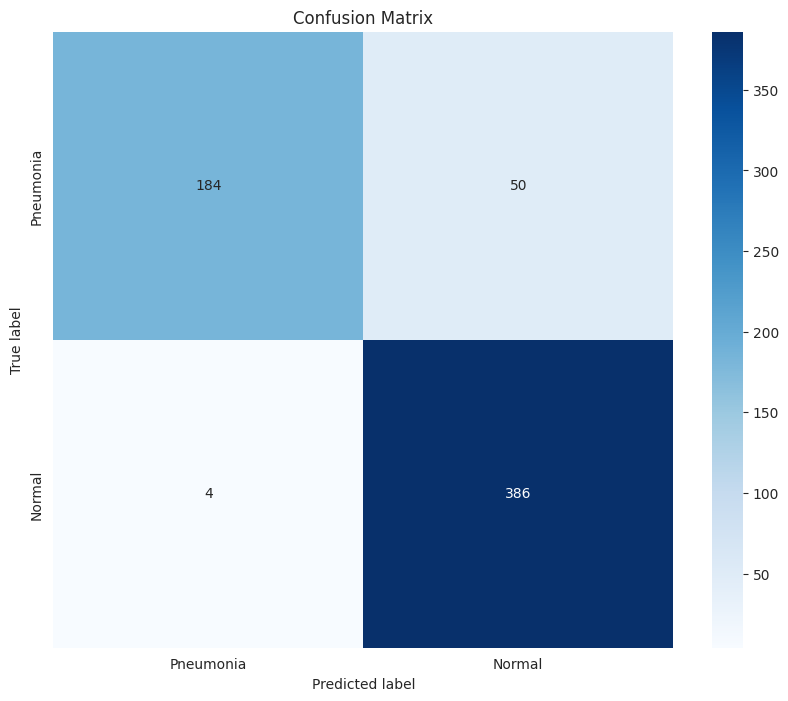

In [ ]:
generate_classification_summary(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, class_names)

Plot misclassification by class

<ipython-input-60-f1092cca4222>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[class_names[i] for i in unique_errors], y=counts, palette="muted")


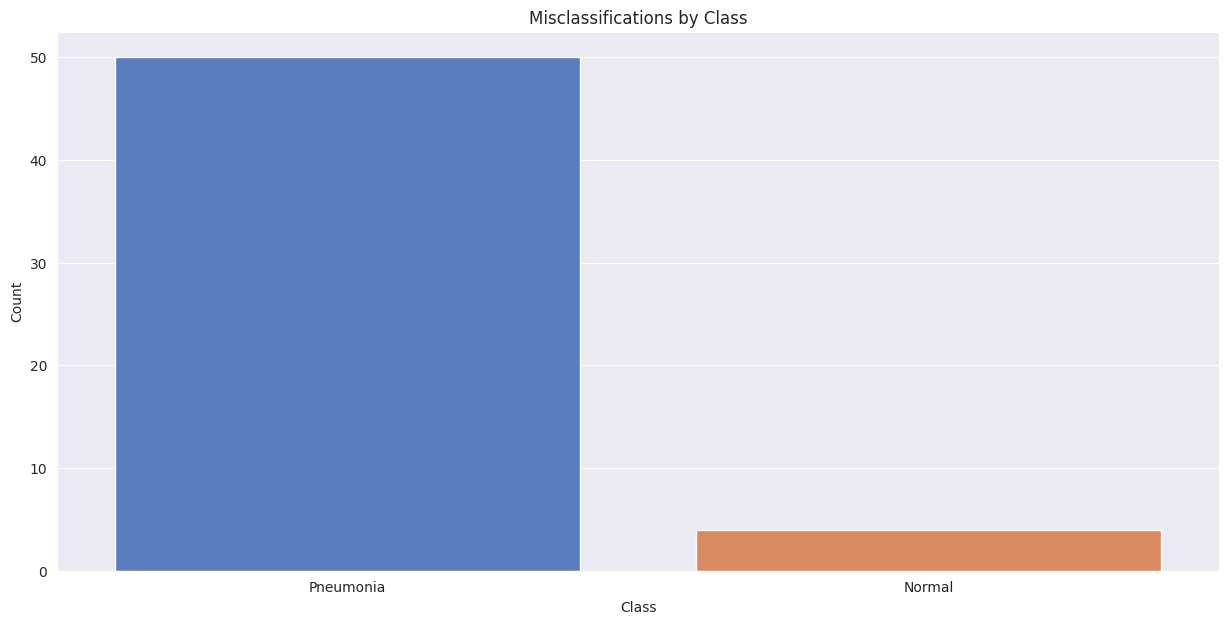

In [ ]:
visualize_misclassifications(y_test, y_pred, class_names)

Show examples of misclassifications

<ipython-input-61-9d5010b3b55a>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 4, i + 1)


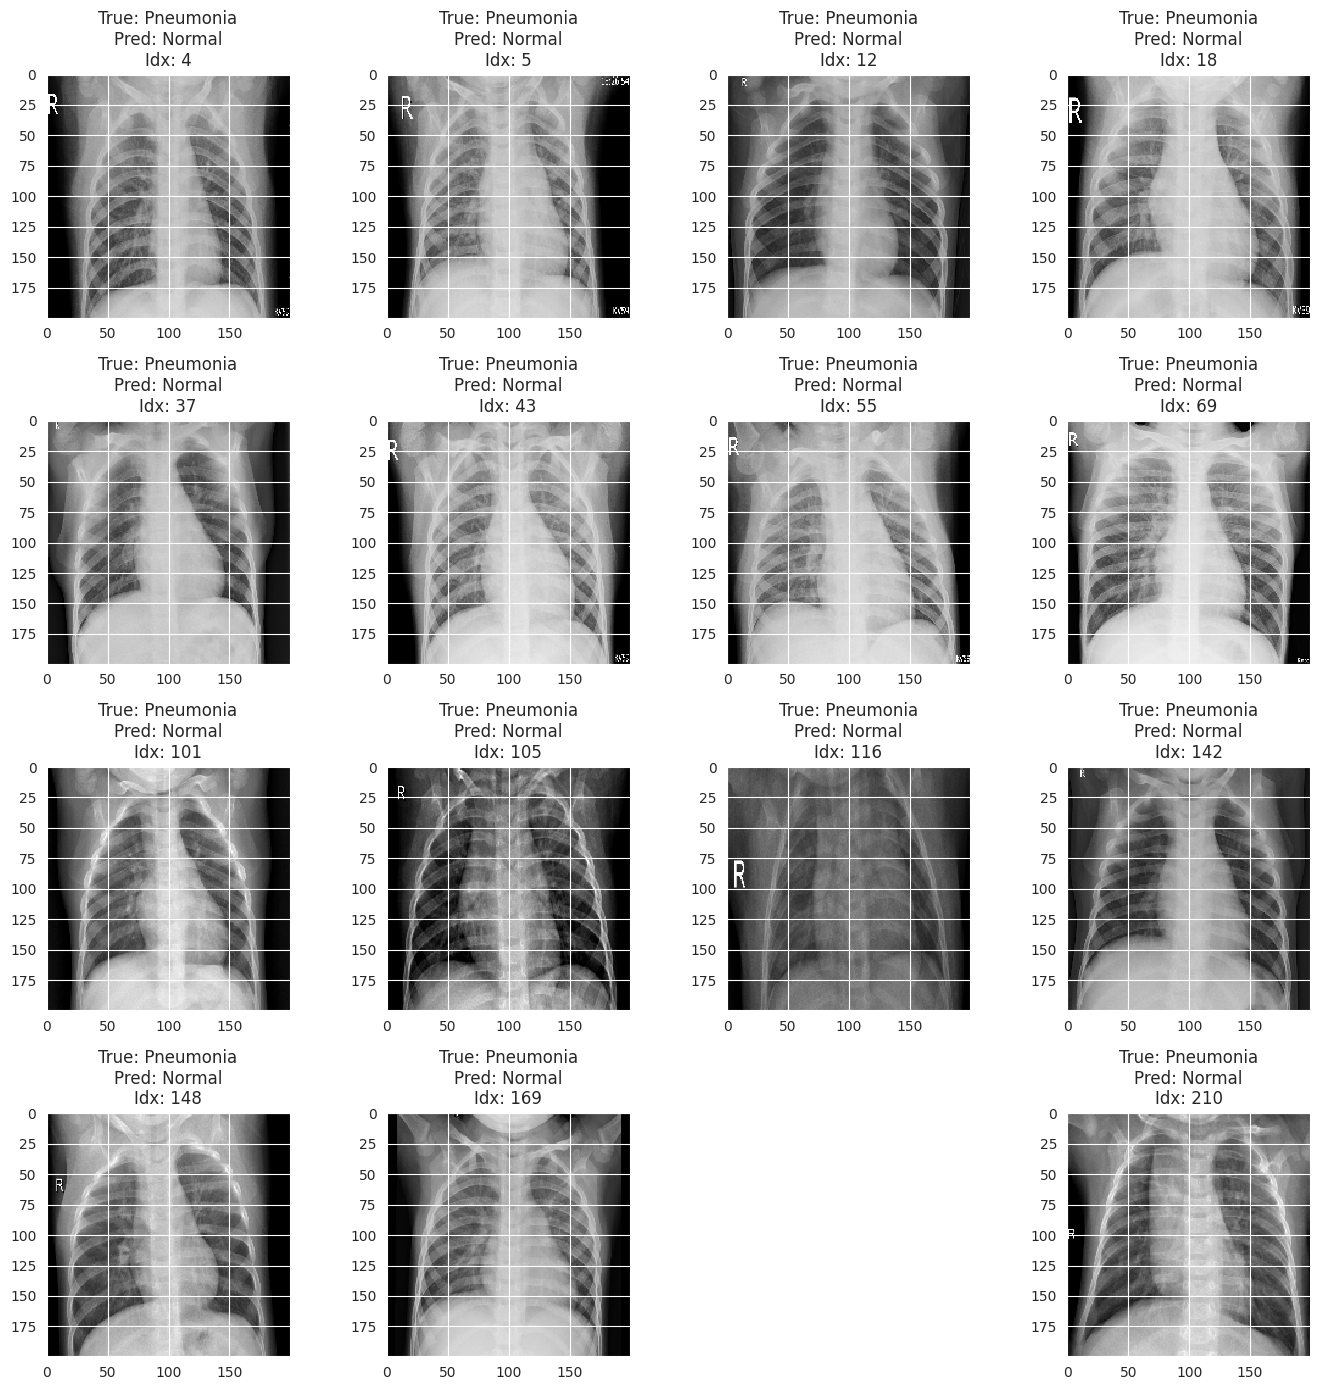

In [ ]:
plot_misclassified_images(X_test, y_test, y_pred, img_size, class_names)

## Explainability

### Select sample

In [ ]:
X = select_random_sample(X_test, y_test) # or select one of the above missclassified cases

idx = random.randint(0, len(X_test) - 1)
instance = X_test[idx]

y_test_labels = convert_one_hot_to_labels(y_test)
ground_truth = y_test_labels[idx]
pred_class = np.argmax(model.predict(X.reshape(1, *X.shape)), axis=1)[0]

### Set up Explainer's parameters

In [ ]:
import random
# Set the target class to the opposite of the predicted class
target_class = 1 - pred_class

# Initialize Counterfactual explainer
shape = (1,) + X_train.shape[1:]
target_proba = 1.0
tol = 0.01  # want counterfactuals with p(class)>0.99
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (X_train.min(), X_train.max())

### Explain instance

The counterfactual starting from the predicted class moves towards the closest *other* class (`normal` or `pneumonia` in our case) as determined by the model .

The evolution of the counterfactual during the iterations over can be seen in the following cell


Explanation took 179.096 sec
Counterfactual prediction: 0 with probability 1.0
Instance shape: (200, 200, 1)
CF image 0 shape: (200, 200)
CF image 1 shape: (200, 200)
CF image 2 shape: (200, 200)
Final CF image shape: (200, 200)
Difference image shape: (200, 200)
Report saved at /content/drive/MyDrive/isbi2024/lung/output/report.png


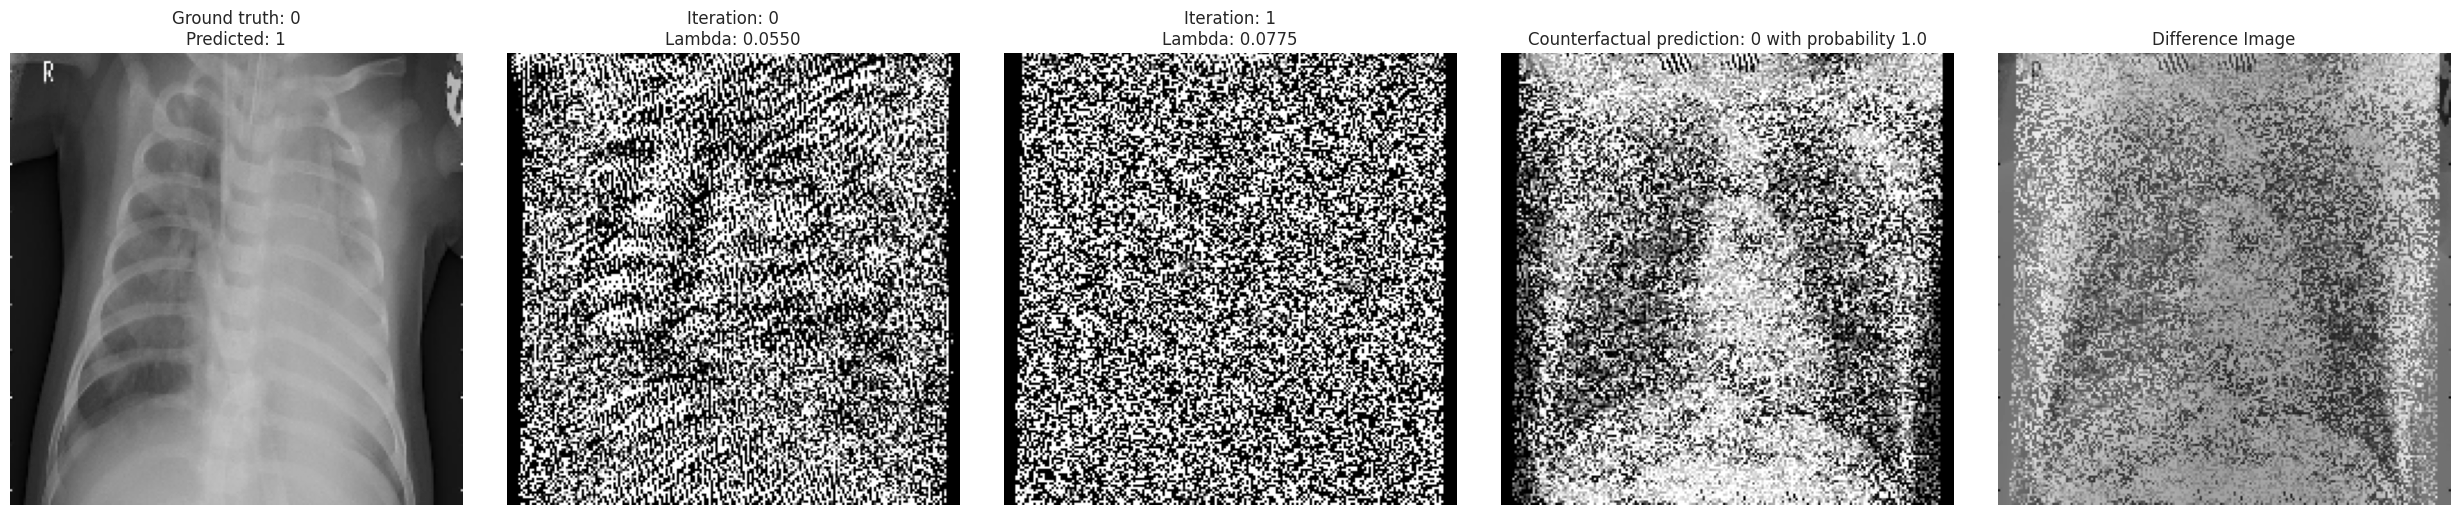

In [ ]:
# Initialize Counterfactual explainer
cf = initialize_counterfactual_explainer(model, shape, target_proba, tol, target_class, max_iter, lam_init, max_lam_steps, learning_rate_init, feature_range)

# Ensure the instance is in the correct shape for the model prediction
instance_reshaped = instance.reshape((1,) + instance.shape)
pred_class = np.argmax(model.predict(instance_reshaped), axis=1)[0]


# Generate counterfactual explanations
explanation, explanation_text, elapsed_time = generate_counterfactual_explanation(cf, instance)


# Generate and save the report image
output_image_path = os.path.join(root, 'output/report.png')
generate_report_image(cf, X, ground_truth, pred_class, explanation, explanation_text, output_image_path)


> note that all of the following examples satisfy the counterfactual condition

According to the method's developers comments, the first few iterations find counterfactuals that are out of distribution, while the later iterations make the counterfactual more sparse and interpretable.